# Ungraded Lab: Class Activation Maps with Fashion MNIST

## Imports

In [1]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
import scipy as sp

2024-07-26 08:40:21.471376: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 08:40:21.471535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 08:40:21.626097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and Prepare the Data

In [2]:
# load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [4]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # remove channel dimension
    img = img.reshape((28,28))

    # display image
    plt.imshow(img)

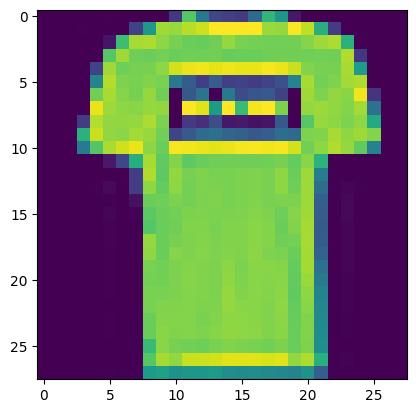

In [5]:
# test the function for the first train image. you can vary the index of X_train
# below to see other images

show_img(X_train[1])

## Build the Classifier

### Define the Model

In [6]:
# use the Sequential API
model = Sequential()
# model.add(Input(shape = (28, 28, 1)))
# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28, 28, 1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,442 (384.54 KB)

 Trainable params: 98,442 (384.54 KB)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [7]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,
          Y_train,
          batch_size=32, 
          epochs=5, 
          validation_split=0.1, 
          shuffle=True)

Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.6779 - loss: 0.8682 - val_accuracy: 0.8445 - val_loss: 0.4260
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8599 - loss: 0.3907 - val_accuracy: 0.8808 - val_loss: 0.3193
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.8843 - loss: 0.3211 - val_accuracy: 0.8918 - val_loss: 0.2919
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.8950 - loss: 0.2839 - val_accuracy: 0.9027 - val_loss: 0.2565
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9098 - loss: 0.2506 - val_accuracy: 0.8992 - val_loss: 0.2755


## Generate the Class Activation Map

In [8]:
# final convolution layer
print(model.layers[-3].name)

# global average pooling layer
print(model.layers[-2].name)

# output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


In [9]:
# Create a new model with the additional output
cam_model = Model(inputs=model.inputs, outputs=[model.layers[-3].output, model.layers[-1].output])

# Print the summary of the new model
cam_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        160 │ input_layer[0][0… │
│                     │ 16)               │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d[6][0],     │
│ (MaxPooling2D)      │ 16)               │            │ conv2d[8][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 14, 14,    │      4,640 │ max_pooling2d[5]… │
│                     │ 32)               │            │ max_pooling2d[7]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 32)  │          0 │ conv2d_1[4][0],   │
│ (MaxPooling2D)      │                   │            │ conv2d_1[6][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 64)  │          0 │ conv2d_2[2][0],   │
│ (MaxPooling2D)      │                   │            │ conv2d_2[4][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 128) │     73,856 │ max_pooling2d_2[… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_3[2][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,442 (384.54 KB)

 Trainable params: 98,442 (384.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


In [11]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


In [12]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


In [13]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=2)

# Check the shape after scaling up to 28 by 28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


In [14]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for 
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


### Conceptual interpretation

In [15]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))
  
  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [16]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 0, Probability = 0.9723755


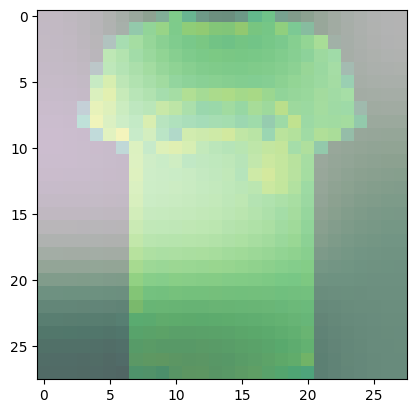

Predicted Class = 0, Probability = 0.8736646


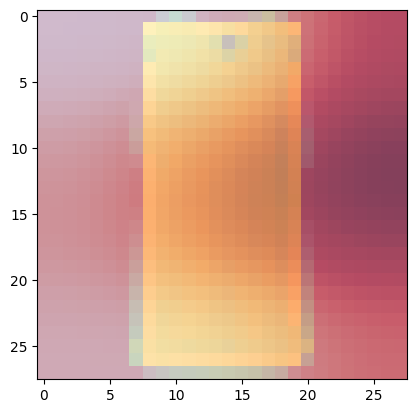

Predicted Class = 0, Probability = 0.94886744


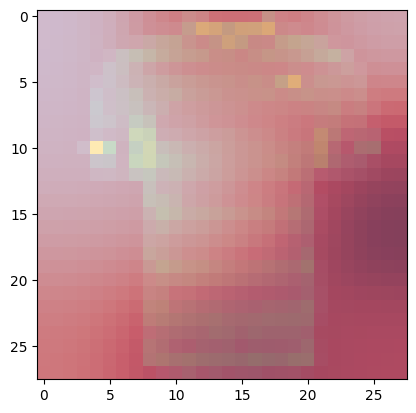

Predicted Class = 0, Probability = 0.4807628


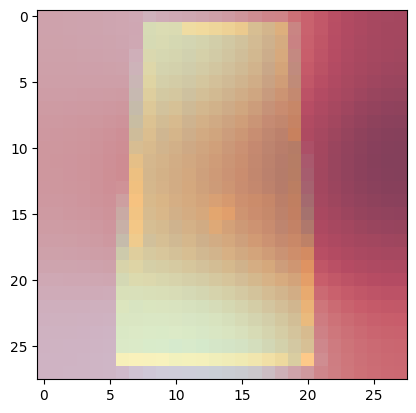

Predicted Class = 0, Probability = 0.99665314


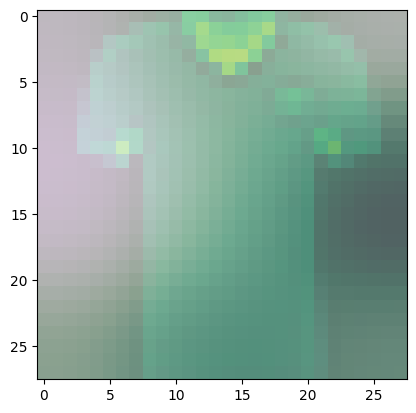

Predicted Class = 0, Probability = 0.9652828


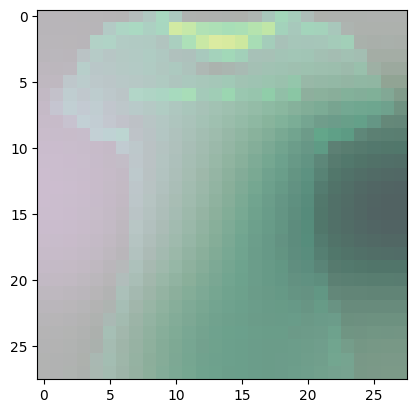

Predicted Class = 0, Probability = 0.982643


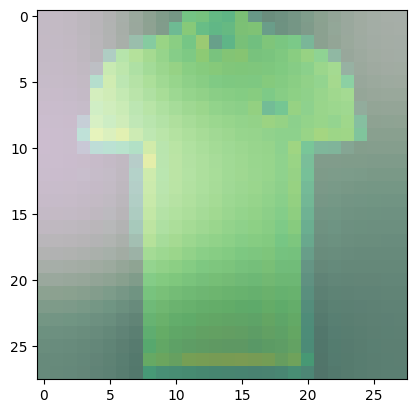

Predicted Class = 0, Probability = 0.99286014


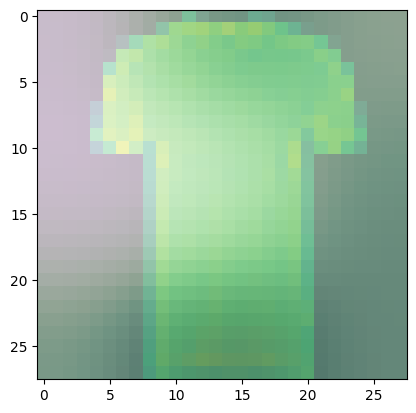

Predicted Class = 0, Probability = 0.8463825


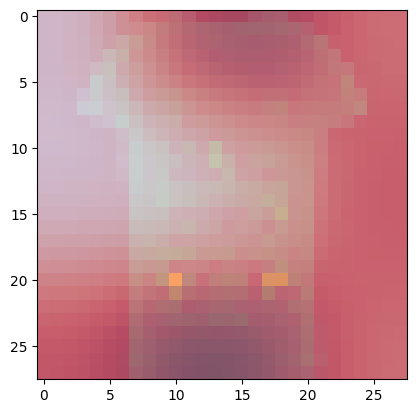

Predicted Class = 0, Probability = 0.8884235


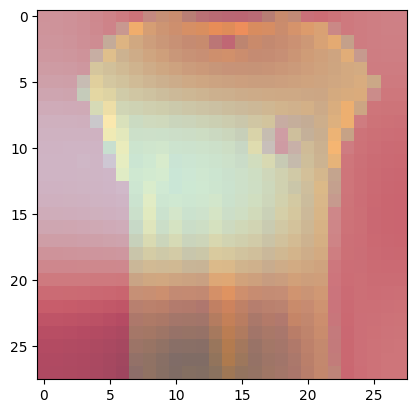

Predicted Class = 0, Probability = 0.9717448


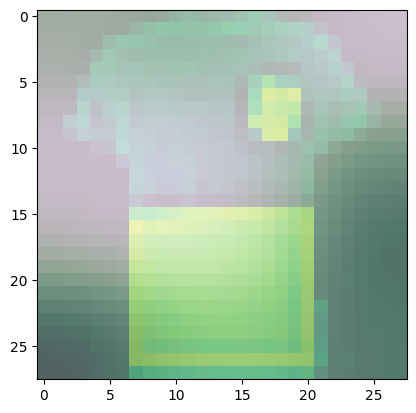

Predicted Class = 0, Probability = 0.99985147


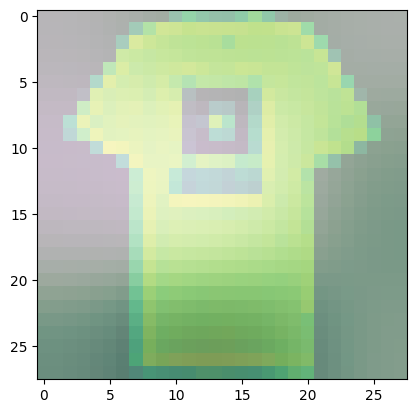

Predicted Class = 0, Probability = 0.98083115


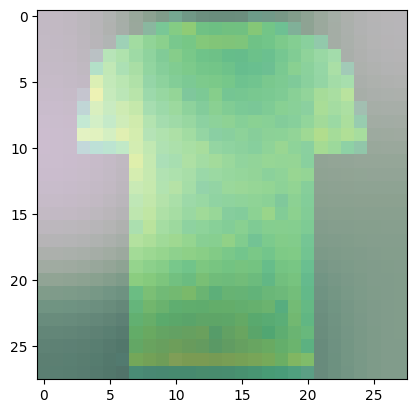

Predicted Class = 0, Probability = 0.56725127


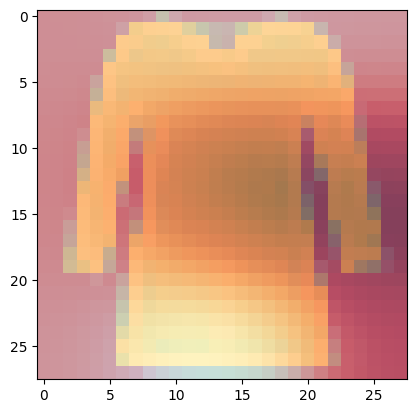

Predicted Class = 0, Probability = 0.9984472


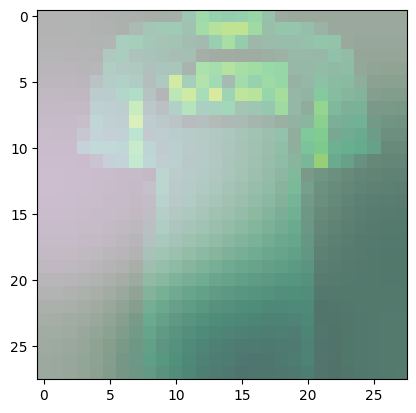

Predicted Class = 0, Probability = 0.9912562


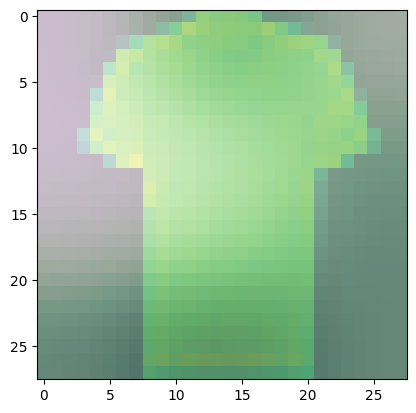

Predicted Class = 0, Probability = 0.5614257


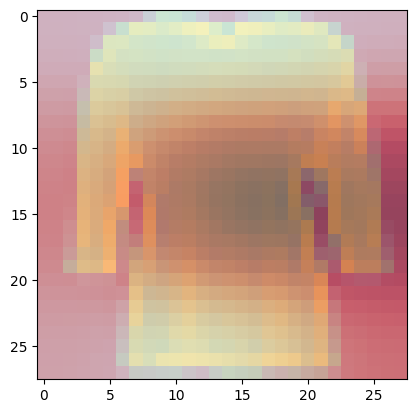

Predicted Class = 0, Probability = 0.99451303


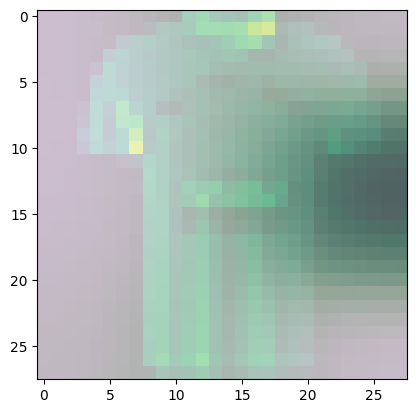

Predicted Class = 0, Probability = 0.7626716


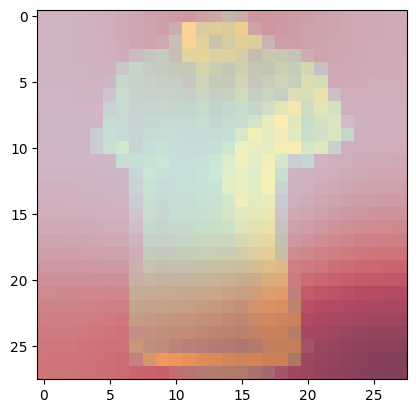

Predicted Class = 0, Probability = 0.943287


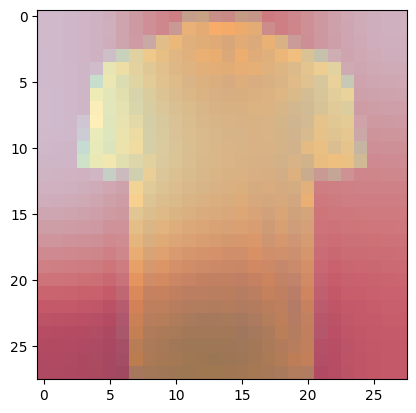

In [18]:
show_maps(desired_class=0, num_maps=20)